In [1]:
%load_ext autoreload
%autoreload 2

## Test: a simple model

In [2]:
from hackaton_eet.data.loaders import get_data
from hackaton_eet.data.transformers import align_data

First, let's get the data. To maket his easier, a helper function `get_data` has been created. As inputs, this function expects a dictionary of your desired datasets, their columns and lags. Note that all lags are given in terms of 15 minutes, and the dates on the column are the day you are trying to predict.

Since we run the model each day at 10:00:00, this means that lag 1 is 09:45:00, and so on.

The code knows of each set which bits are known in advance and which parts are only known after the fact, and will only return the data you have available at each time. It is highly recommended to use this function instead of writing your own.

In [35]:
feature_datasets = {
    'tennet.verrekenprijzen': {
        'lags': [1,],  # Lags are now days. Makes working with them easier
        'columns': ['invoeden', 'Afnemen']
    },
#     'reuters.dayahead' : {
#         'columns': ['Wind_NLD', 'CON_NLD'],
#         'lags': [1,]
#     }
}
target_dataset = {
    'tennet.target': {
        'columns': ['invoeden', 'Afnemen'],
        'lags': [1]
    }
}

feature_data = get_data(feature_datasets)
target_data = get_data(target_dataset)

[[    8     9    10 ..., 72966 72967 72968]]
[[  200   201   202 ..., 73062 73063 73064]]


In [36]:
feature_data

datetime,2014-05-02 02:00:00+02:00,2014-05-02 02:15:00+02:00,2014-05-02 02:30:00+02:00,2014-05-02 02:45:00+02:00,2014-05-02 03:00:00+02:00,2014-05-02 03:15:00+02:00,2014-05-02 03:30:00+02:00,2014-05-02 03:45:00+02:00,2014-05-02 04:00:00+02:00,2014-05-02 04:15:00+02:00,...,2016-05-30 23:45:00+02:00,2016-05-31 00:00:00+02:00,2016-05-31 00:15:00+02:00,2016-05-31 00:30:00+02:00,2016-05-31 00:45:00+02:00,2016-05-31 01:00:00+02:00,2016-05-31 01:15:00+02:00,2016-05-31 01:30:00+02:00,2016-05-31 01:45:00+02:00,2016-05-31 02:00:00+02:00
tennet.verrekenprijzen.invoeden.lag_1,35.29,37.63,35.6,35.01,35.23,35.23,35.23,35.23,35.23,34.9,...,21.73,26.69,26.69,16.73,-150.78,350.12,8.13,20.59,16.73,23.73
tennet.verrekenprijzen.Afnemen.lag_1,35.29,37.63,35.6,35.01,35.23,35.23,35.23,35.23,35.23,34.9,...,21.73,22.78,26.69,16.73,-150.78,350.12,8.13,20.59,16.73,23.73


In [37]:
target_data

datetime,2014-05-03 02:00:00+02:00,2014-05-03 02:15:00+02:00,2014-05-03 02:30:00+02:00,2014-05-03 02:45:00+02:00,2014-05-03 03:00:00+02:00,2014-05-03 03:15:00+02:00,2014-05-03 03:30:00+02:00,2014-05-03 03:45:00+02:00,2014-05-03 04:00:00+02:00,2014-05-03 04:15:00+02:00,...,2016-05-30 23:45:00+02:00,2016-05-31 00:00:00+02:00,2016-05-31 00:15:00+02:00,2016-05-31 00:30:00+02:00,2016-05-31 00:45:00+02:00,2016-05-31 01:00:00+02:00,2016-05-31 01:15:00+02:00,2016-05-31 01:30:00+02:00,2016-05-31 01:45:00+02:00,2016-05-31 02:00:00+02:00
invoeden,21.0,21.0,18.5,15.26,26.5,18.5,18.5,28.03,29.77,29.77,...,36.23,-41.03,20.74,21.74,-150.03,34.92,62.68,20.74,24.12,24.15
Afnemen,21.0,21.0,18.5,15.26,26.5,18.5,18.5,28.03,29.77,29.77,...,36.23,-41.03,20.74,21.74,-150.03,-150.03,20.74,20.74,24.12,24.15


In [ ]:
import pandas as pd
pd.DataFrame(feature_data)

## Training the model

In [50]:
feature_data

,2014-05-02,2014-05-03,2014-05-04,2014-05-05,2014-05-06,2014-05-07,2014-05-08,2014-05-09,2014-05-10,2014-05-11,...,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30
tennet.verrekenprijzen.invoeden.lag_2,42.9,37.12,18.5,31.0,31.9,35.5,36.64,50.94,53.00,51.00,...,24.81,23.27,38.7,23.76,23.12,32.49,26.12,40.07,48.54,33.73
tennet.verrekenprijzen.invoeden.lag_1,36.0,35.86,51.1,31.0,31.9,35.5,36.98,46.94,37.05,56.49,...,25.49,23.53,51.9,23.76,22.76,30.95,26.83,60.45,50.97,55.02
tennet.verrekenprijzen.Afnemen.lag_2,42.9,37.12,18.5,31.0,31.9,35.5,36.64,50.94,53.00,51.00,...,24.81,23.27,38.7,23.76,23.12,32.49,26.12,40.07,48.54,33.73
tennet.verrekenprijzen.Afnemen.lag_1,36.0,35.86,51.1,31.0,31.9,35.5,36.98,46.94,37.05,56.49,...,25.49,21.27,51.9,23.76,22.76,23.92,26.83,60.45,50.97,55.02


In [51]:
target_data

,2014-05-02,2014-05-03,2014-05-04,2014-05-05,2014-05-06,2014-05-07,2014-05-08,2014-05-09,2014-05-10,2014-05-11,...,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30
tennet.target.invoeden.lag_2,37.12,18.5,31.0,31.9,35.5,36.64,50.94,53.00,51.00,27.03,...,23.27,38.7,23.76,23.12,32.49,26.12,40.07,48.54,33.73,33.12
tennet.target.invoeden.lag_1,35.86,51.1,31.0,31.9,35.5,36.98,46.94,37.05,56.49,36.05,...,23.53,51.9,23.76,22.76,30.95,26.83,60.45,50.97,55.02,26.06
tennet.target.Afnemen.lag_2,37.12,18.5,31.0,31.9,35.5,36.64,50.94,53.00,51.00,27.03,...,23.27,38.7,23.76,23.12,32.49,26.12,40.07,48.54,33.73,33.12
tennet.target.Afnemen.lag_1,35.86,51.1,31.0,31.9,35.5,36.98,46.94,37.05,56.49,36.05,...,21.27,51.9,23.76,22.76,23.92,26.83,60.45,50.97,55.02,26.06


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score

In [40]:
X = feature_data.fillna(0).values
y = target_data.fillna(0).values

X, y = align_data(X, y)

X, y = X.T, y.T

X_train, X_test = X[:250], X[250:]
y_train, y_test = y[:250], y[250:]

In [41]:
est = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    n_jobs=-1,
).fit(X_train, y_train)
y_pred = est.predict(X_test)

So, did it work?

In [42]:
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print("VAF: %.2f" % explained_variance_score(y_test, y_pred))

MAE: 37.56
VAF: -0.01


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

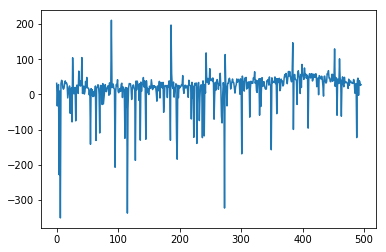

In [44]:
plt.plot(y_pred[:, 1] - y_test[:, 1])